In [10]:
import json
import os
import warnings
# ignore warnings
warnings.filterwarnings("ignore")

def load_coco_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

# Example usage
annotations = load_coco_annotations('../datasets/archive/sample_synth_datasets/ds5.0/train__inst_coco.json')
print("Categories:", annotations['categories'])
print("Number of images:", len(annotations['images']))

Categories: [{'name': 'dial', 'id': 1}, {'name': 'casing', 'id': 2}, {'name': 'face_plate', 'id': 3, 'keypoints': ['dial_max', 'dial_min', 'dial_center', 'dial_tip'], 'skeleton': [[2, 0], [2, 1], [2, 3]]}, {'name': 'scale-label', 'id': 4}]
Number of images: 799


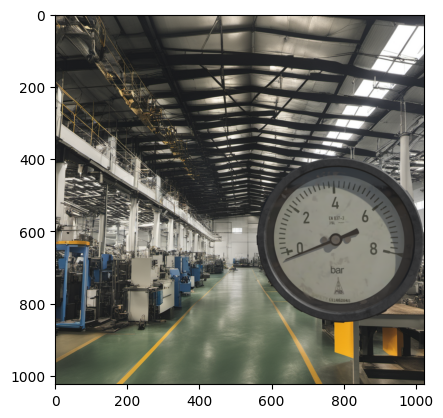

In [12]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_path, bboxes, image_metadata):
    """
    Draw bounding boxes on an image.

    Args:
        image_path (str): Path to the image.
        bboxes (list): List of bounding boxes [[x, y, w, h], ...].
        image_metadata (dict): Contains width and height of the image.

    Returns:
        Annotated image.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for bbox in bboxes:
        x, y, w, h = bbox
        # Scale bbox coordinates to the image size if they are normalized
        x = int(x * image_metadata['width'])
        y = int(y * image_metadata['height'])
        w = int(w * image_metadata['width'])
        h = int(h * image_metadata['height'])

        # Draw rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return img

# Example usage
coco_annotations = load_coco_annotations('../datasets/archive/sample_synth_datasets/ds5.0/train__inst_coco.json')
image_metadata = coco_annotations['images'][0]
image_path = f"../datasets/archive/sample_synth_datasets/ds5.0/{image_metadata['file_name']}"
annotations = [ann['bbox'] for ann in coco_annotations['annotations'] if ann['image_id'] == image_metadata['id']]
annotated_img = draw_bounding_boxes(image_path, annotations, image_metadata)

plt.imshow(annotated_img)
plt.show()

In [13]:
import tensorflow as tf
def create_tf_example(image_metadata, annotations, image_dir):
    """
    Create a tf.train.Example for one image and its annotations.

    Args:
        image_metadata (dict): Image metadata from COCO.
        annotations (list): Annotations for the image.
        image_dir (str): Directory containing the images.

    Returns:
        tf.train.Example
    """
    # Load image
    image_path = os.path.join(image_dir, image_metadata['file_name'])
    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image = fid.read()

    width = image_metadata['width']
    height = image_metadata['height']

    # Extract bounding boxes and labels
    x_mins, y_mins, x_maxs, y_maxs, classes = [], [], [], [], []
    for ann in annotations:
        bbox = ann['bbox']
        x_min = bbox[0] / width
        y_min = bbox[1] / height
        x_max = (bbox[0] + bbox[2]) / width
        y_max = (bbox[1] + bbox[3]) / height

        x_mins.append(x_min)
        y_mins.append(y_min)
        x_maxs.append(x_max)
        y_maxs.append(y_max)
        classes.append(ann['category_id'])

    # Create TFRecord example
    feature = {
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=x_mins)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=y_mins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=x_maxs)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=y_maxs)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


2024-12-29 00:06:50.869394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735411010.964662   14925 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735411010.991856   14925 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 00:06:51.253018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def convert_to_tfrecord(annotation_file, image_dir, output_path):
    """
    Convert COCO annotations and images to TFRecord format.

    Args:
        annotation_file (str): Path to the COCO JSON file.
        image_dir (str): Path to the images directory.
        output_path (str): Output TFRecord file path.
    """
    coco_annotations = load_coco_annotations(annotation_file)
    with tf.io.TFRecordWriter(output_path) as writer:
        for image in coco_annotations['images']:
            image_annotations = [
                ann for ann in coco_annotations['annotations'] if ann['image_id'] == image['id']
            ]
            tf_example = create_tf_example(image, image_annotations, image_dir)
            writer.write(tf_example.SerializeToString())

# Convert dataset
convert_to_tfrecord('../datasets/archive/sample_synth_datasets/ds5.0/train__inst_coco.json', '../datasets/archive/sample_synth_datasets/ds5.0', 'train.tfrecord')
convert_to_tfrecord('../datasets/archive/sample_synth_datasets/ds5.0/val__inst_coco.json', '../datasets/archive/sample_synth_datasets/ds5.0', 'val.tfrecord')


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_ssd_model(num_classes, max_boxes=8):
    """
    Create an SSD model based on MobileNetV2 for multiple object detection.
    Args:
        num_classes: Number of object classes to detect
        max_boxes: Maximum number of objects to detect per image
    """
    # Base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(300, 300, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze base model weights
    
    # Feature maps from different layers
    x = base_model.output
    
    # Additional convolutional layers for detection
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    
    # Flatten features
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dense layers for feature processing
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Multiple detection heads
    # Shape will be (batch_size, max_boxes, num_classes) for classification
    class_branch = layers.Dense(256, activation='relu')(x)
    class_output = layers.Dense(max_boxes * num_classes)(class_branch)
    class_output = layers.Reshape((max_boxes, num_classes))(class_output)
    # Important: The softmax activation is now part of the same named layer
    class_output = layers.Activation('softmax', name='class_output')(class_output)
    
    # Shape will be (batch_size, max_boxes, 4) for bounding boxes
    bbox_branch = layers.Dense(256, activation='relu')(x)
    bbox_output = layers.Dense(max_boxes * 4)(bbox_branch)
    bbox_output = layers.Reshape((max_boxes, 4), name='bbox_output')(bbox_output)
    
    # Create model
    model = models.Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    return model

def compile_model(model):
    """
    Compile the model with appropriate loss functions and metrics
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'class_output': 'sparse_categorical_crossentropy',
            'bbox_output': 'mse'
        },
        loss_weights={
            'class_output': 1.0,
            'bbox_output': 1.0
        },
        metrics={
            'class_output': 'accuracy',
            'bbox_output': 'mae'
        }
    )

# Usage example
def main():
    # Configuration
    NUM_CLASSES = 4  # dial, casing, face_plate, scale-label
    MAX_BOXES = 8    # Maximum number of objects per image
    
    # Create and compile model
    model = create_ssd_model(NUM_CLASSES, MAX_BOXES)
    compile_model(model)
    
    # Print model summary
    model.summary()
    
    return model

In [41]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    parsed = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=4)
    image = image[..., :3]  # Drop alpha channel
    image = tf.image.resize(image, (300, 300)) / 255.0  # Normalize to [0, 1]
    
    # Extract bounding boxes
    bbox = tf.stack([
        tf.sparse.to_dense(parsed['image/object/bbox/xmin']),
        tf.sparse.to_dense(parsed['image/object/bbox/ymin']),
        tf.sparse.to_dense(parsed['image/object/bbox/xmax']),
        tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    ], axis=-1)

    # Pad to a fixed number of boxes (e.g., 8)
    max_boxes = 8
    bbox = tf.pad(bbox, [[0, max_boxes - tf.shape(bbox)[0]], [0, 0]])  # Pad with zeros
    bbox = bbox[:max_boxes]  # Truncate if there are more than `max_boxes`
    
    # Extract the first class label (or aggregate logic)
    label = tf.sparse.to_dense(parsed['image/object/class/label'])[0]
    
    return image, (label, bbox)



def load_dataset(tfrecord_path, batch_size=32):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = load_dataset('train.tfrecord')
val_dataset = load_dataset('val.tfrecord')

In [42]:
# model.add(layers.InputLayer(input_shape=(224, 224, 3)))

# model.compile(
#     optimizer='adam',
#     loss={
#         'class_output': 'sparse_categorical_crossentropy',
#         'bbox_output': 'mse'
#     },
#     metrics={
#         'class_output': 'accuracy',
#         'bbox_output': 'mae'
#     }
# )
model = create_ssd_model(num_classes=4)  # 4 classes: dial, casing, face_plate, scale-label
compile_model(model)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


ValueError: Expected keys ListWrapper(['activation_1', 'bbox_output']) in loss dict, but found loss.keys()=['class_output', 'bbox_output']

In [33]:
for data, label in train_dataset.take(1):
    print(data.shape)

(32, 300, 300, 4)


In [34]:
model_input_shape = model.input_shape  # Check expected input shape
print(f"Model expects input shape: {model_input_shape}")


Model expects input shape: (None, 300, 300, 3)


In [44]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    parsed = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image
    image = tf.image.decode_jpeg(parsed['image/encoded'], channels=4)
    image = image[..., :3]  # Drop alpha channel
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalize to [0, 1]
    
    # Extract bounding boxes
    bbox = tf.stack([
        tf.sparse.to_dense(parsed['image/object/bbox/xmin']),
        tf.sparse.to_dense(parsed['image/object/bbox/ymin']),
        tf.sparse.to_dense(parsed['image/object/bbox/xmax']),
        tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    ], axis=-1)
    
    # Extract labels
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])
    
    # Pad both bboxes and labels to fixed size
    max_boxes = 8
    paddings_bbox = [[0, max_boxes - tf.shape(bbox)[0]], [0, 0]]
    paddings_labels = [[0, max_boxes - tf.shape(labels)[0]]]
    
    bbox = tf.pad(bbox, paddings_bbox)
    labels = tf.pad(labels, paddings_labels)
    
    # Ensure fixed size by slicing
    bbox = bbox[:max_boxes]
    labels = labels[:max_boxes]
    
    return image, {'class_output': labels, 'bbox_output': bbox}

def load_dataset(tfrecord_path, batch_size=32):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord_fn)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def create_model(num_classes, max_boxes=8):
    # Base model (you can replace this with your preferred architecture)
    base_input = layers.Input(shape=(224, 224, 3), name='input_image')
    
    # Simple convolutional backbone
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(base_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Classification head
    class_output = layers.Dense(max_boxes * num_classes, activation='softmax')(x)
    class_output = layers.Reshape((max_boxes, num_classes), name='class_output')(class_output)
    
    # Bounding box regression head
    bbox_output = layers.Dense(max_boxes * 4)(x)
    bbox_output = layers.Reshape((max_boxes, 4), name='bbox_output')(bbox_output)
    
    model = Model(inputs=base_input, outputs=[class_output, bbox_output])
    return model

# Usage example
num_classes = 10  # Replace with your actual number of classes
max_boxes = 8

# Create and compile model
model = create_model(num_classes, max_boxes)
model.compile(
    optimizer='adam',
    loss={
        'class_output': 'sparse_categorical_crossentropy',
        'bbox_output': 'mse'
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mae'
    }
)

# Load datasets
train_dataset = load_dataset('train.tfrecord')
val_dataset = load_dataset('val.tfrecord')

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


W0000 00:00:1735414135.116204   29483 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1735414135.201089   29483 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-29 00:58:55.931405: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_855', 20 bytes spill stores, 20 bytes spill loads

2024-12-29 00:58:56.067537: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_855', 20 bytes spill stores, 20 bytes spill loads



      2/Unknown 12s 89ms/step - bbox_output_loss: 28.1533 - bbox_output_mae: 2.6670 - class_output_accuracy: 0.3613 - class_output_loss: 1.7349 - loss: 29.8882

I0000 00:00:1735414143.436429   29483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     24/Unknown 14s 87ms/step - bbox_output_loss: 13.7285 - bbox_output_mae: 1.6925 - class_output_accuracy: 0.8660 - class_output_loss: 0.8332 - loss: 14.5617

W0000 00:00:1735414145.624646   29483 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-29 00:59:06.506764: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_855', 20 bytes spill stores, 20 bytes spill loads



     25/Unknown 22s 409ms/step - bbox_output_loss: 13.3771 - bbox_output_mae: 1.6583 - class_output_accuracy: 0.8700 - class_output_loss: 0.8161 - loss: 14.1935

2024-12-29 00:59:13.345265: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:13.345306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:13.345325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296
W0000 00:00:1735414154.178791   29483 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1735414156.536570   29486 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 602ms/step - bbox_output_loss: 13.0527 - bbox_output_mae: 1.6267 - class_output_accuracy: 0.8737 - class_output_loss: 0.8003 - loss: 13.8535 - val_bbox_output_loss: 0.0548 - val_bbox_output_mae: 0.1881 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0047 - val_loss: 0.0603
Epoch 2/10


2024-12-29 00:59:17.962216: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:17.962274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:17.962294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - bbox_output_loss: 0.0356 - bbox_output_mae: 0.1495 - class_output_accuracy: 1.0000 - class_output_loss: 0.0049 - loss: 0.0406 - val_bbox_output_loss: 0.0265 - val_bbox_output_mae: 0.1350 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0012 - val_loss: 0.0277
Epoch 3/10


2024-12-29 00:59:23.219655: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-12-29 00:59:23.219690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:23.219699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:23.219710: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - bbox_output_loss: 0.0221 - bbox_output_mae: 0.1212 - class_output_accuracy: 1.0000 - class_output_loss: 6.4882e-04 - loss: 0.0227 - val_bbox_output_loss: 0.0261 - val_bbox_output_mae: 0.1313 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.5029e-04 - val_loss: 0.0255
Epoch 4/10


2024-12-29 00:59:28.676039: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:28.676083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:28.676094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - bbox_output_loss: 0.0213 - bbox_output_mae: 0.1195 - class_output_accuracy: 1.0000 - class_output_loss: 2.1778e-04 - loss: 0.0215

2024-12-29 00:59:33.253919: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:33.253952: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:33.253964: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - bbox_output_loss: 0.0213 - bbox_output_mae: 0.1194 - class_output_accuracy: 1.0000 - class_output_loss: 2.1647e-04 - loss: 0.0215 - val_bbox_output_loss: 0.0230 - val_bbox_output_mae: 0.1242 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 1.0968e-04 - val_loss: 0.0229
Epoch 5/10


2024-12-29 00:59:34.016805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:34.016850: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:34.016864: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - bbox_output_loss: 0.0200 - bbox_output_mae: 0.1148 - class_output_accuracy: 1.0000 - class_output_loss: 1.3726e-04 - loss: 0.0201 - val_bbox_output_loss: 0.0228 - val_bbox_output_mae: 0.1227 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 1.0097e-04 - val_loss: 0.0225
Epoch 6/10


2024-12-29 00:59:39.291367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:39.291417: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:39.291437: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - bbox_output_loss: 0.0171 - bbox_output_mae: 0.1044 - class_output_accuracy: 1.0000 - class_output_loss: 1.1140e-04 - loss: 0.0173

2024-12-29 00:59:45.797652: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - bbox_output_loss: 0.0172 - bbox_output_mae: 0.1045 - class_output_accuracy: 1.0000 - class_output_loss: 1.1044e-04 - loss: 0.0173 - val_bbox_output_loss: 0.0203 - val_bbox_output_mae: 0.1162 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 5.8904e-05 - val_loss: 0.0206
Epoch 7/10


2024-12-29 00:59:46.560278: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-12-29 00:59:46.560323: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:46.560335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:46.560346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - bbox_output_loss: 0.0153 - bbox_output_mae: 0.0974 - class_output_accuracy: 1.0000 - class_output_loss: 7.4800e-05 - loss: 0.0154 - val_bbox_output_loss: 0.0170 - val_bbox_output_mae: 0.1052 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 5.1463e-05 - val_loss: 0.0176
Epoch 8/10


2024-12-29 00:59:51.791645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:51.791699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:51.791719: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - bbox_output_loss: 0.0122 - bbox_output_mae: 0.0852 - class_output_accuracy: 1.0000 - class_output_loss: 5.3675e-05 - loss: 0.0122 - val_bbox_output_loss: 0.0146 - val_bbox_output_mae: 0.0909 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.5034e-05 - val_loss: 0.0139
Epoch 9/10


2024-12-29 00:59:57.135202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 00:59:57.135240: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 00:59:57.135251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - bbox_output_loss: 0.0097 - bbox_output_mae: 0.0751 - class_output_accuracy: 1.0000 - class_output_loss: 4.9500e-05 - loss: 0.0097 - val_bbox_output_loss: 0.0119 - val_bbox_output_mae: 0.0847 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.2973e-05 - val_loss: 0.0124
Epoch 10/10


2024-12-29 01:00:02.446193: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 01:00:02.446243: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 01:00:02.446262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - bbox_output_loss: 0.0084 - bbox_output_mae: 0.0707 - class_output_accuracy: 1.0000 - class_output_loss: 4.8514e-05 - loss: 0.0084 - val_bbox_output_loss: 0.0104 - val_bbox_output_mae: 0.0811 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 4.4577e-05 - val_loss: 0.0112


2024-12-29 01:00:10.076577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14172307906649481473
2024-12-29 01:00:10.076621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7577047337350654922
2024-12-29 01:00:10.076633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5934617041121996296


In [45]:
import tensorflow as tf

def convert_to_tflite(model, quantize=True):
    """
    Convert TensorFlow model to TFLite format with optional quantization
    Args:
        model: Trained TensorFlow model
        quantize: Boolean to enable/disable quantization
    Returns:
        TFLite model content
    """
    # Create TFLite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    if quantize:
        # Configure the converter for int8 quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.TFLITE_BUILTINS_INT8
        ]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.float32
        
        # Define representative dataset for quantization
        def representative_dataset():
            for data in train_dataset.take(100):  # Use 100 samples from training data
                image = data[0]
                yield [image]
        
        converter.representative_dataset = representative_dataset

    # Convert the model
    tflite_model = converter.convert()
    
    return tflite_model

def save_tflite_model(tflite_model, filename):
    """
    Save TFLite model to file
    """
    with open(filename, 'wb') as f:
        f.write(tflite_model)
    print(f"Model saved to {filename}")

# Convert and save model
tflite_model = convert_to_tflite(model, quantize=True)
save_tflite_model(tflite_model, 'object_detection_model.tflite')

# Optional: Verify the model size
import os
model_size = os.path.getsize('object_detection_model.tflite') / (1024 * 1024)
print(f"TFLite model size: {model_size:.2f} MB")

# Optional: Test the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Input Details:")
print(f"Shape: {input_details[0]['shape']}")
print(f"Type: {input_details[0]['dtype']}")

print("\nModel Output Details:")
for output in output_details:
    print(f"Name: {output['name']}")
    print(f"Shape: {output['shape']}")
    print(f"Type: {output['dtype']}")

INFO:tensorflow:Assets written to: /tmp/tmpz2i93at7/assets


INFO:tensorflow:Assets written to: /tmp/tmpz2i93at7/assets


Saved artifact at '/tmp/tmpz2i93at7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  List[TensorSpec(shape=(None, 8, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8, 4), dtype=tf.float32, name=None)]
Captures:
  126957504347216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957504347600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957504347792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490816208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490816400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490816976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490817168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490817744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126957490818704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12695749081928

W0000 00:00:1735414347.316757   14925 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1735414347.316772   14925 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-29 01:02:27.317055: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpz2i93at7
2024-12-29 01:02:27.317575: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-29 01:02:27.317590: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpz2i93at7
I0000 00:00:1735414347.322020   14925 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-12-29 01:02:27.322818: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-29 01:02:27.649758: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpz2i93at7
2024-12-29 01:02:27.658251: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

Model saved to object_detection_model.tflite
TFLite model size: 98.44 MB

Model Input Details:
Shape: [  1 224 224   3]
Type: <class 'numpy.uint8'>

Model Output Details:
Name: StatefulPartitionedCall_1:1
Shape: [1 8 4]
Type: <class 'numpy.float32'>
Name: StatefulPartitionedCall_1:0
Shape: [ 1  8 10]
Type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
